In [1]:
# ライブラリのインポート
import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx
import os
import zipfile
import matplotlib.pyplot as plt
import japanize_matplotlib 
from matplotlib.ticker import MaxNLocator
from tqdm.auto import tqdm
from shapely.geometry import LineString, Point
import datetime as dt
from pathlib import Path
import pydeck as pdk
import numpy as np
import math
from geopy.distance import geodesic

from shapely.wkt import loads

import gurobipy as gu
from gurobipy import Model, GRB
import logging
import cmasher as cmr
import matplotlib




In [2]:
# --- 定数定義 ---
# パス設定
PROJECT_ROOT = "../"
DATA_DIR = PROJECT_ROOT + 'data/'
OUTPUT_DIR = PROJECT_ROOT + 'output/'
INTERMEDIATE_OUTPUT_DIR = OUTPUT_DIR + 'intermediate_data/'

# 入力データパス
AGRI_DIR = DATA_DIR + 'agricultural_settlements/'
DEM_DIR = DATA_DIR  + 'DEM250/'
PGV_DIR = DATA_DIR + 'jshis_pgv/'
POP_DIR = DATA_DIR + 'population/'
MESH_DIR = DATA_DIR + 'mesh/'

# 座標参照系 (CRS)
TARGET_CRS = "EPSG:4612"
WGS84_CRS = "EPSG:4326" # 緯度経度計算用のCRS

# 出力ファイルパス
AGRI_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'agri_gdf.pkl'
DEM_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'dem_gdf.pkl'
PGV_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'pgv_gdf.pkl'
ROAD_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'road_gdf.pkl'

In [3]:
import pickle

with open(AGRI_GDF_PKL, 'rb') as file:
    agri_gdf = pickle.load(file)

with open(PGV_GDF_PKL, 'rb') as file:
    pgv_gdf = pickle.load(file)

with open(DEM_GDF_PKL, 'rb') as file:
    dem_gdf = pickle.load(file)

with open(ROAD_GDF_PKL, 'rb') as file:
    road_gdf = pickle.load(file)


#### 道路ネットワークデータ（osmnx使用）

/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_51783/181833144.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


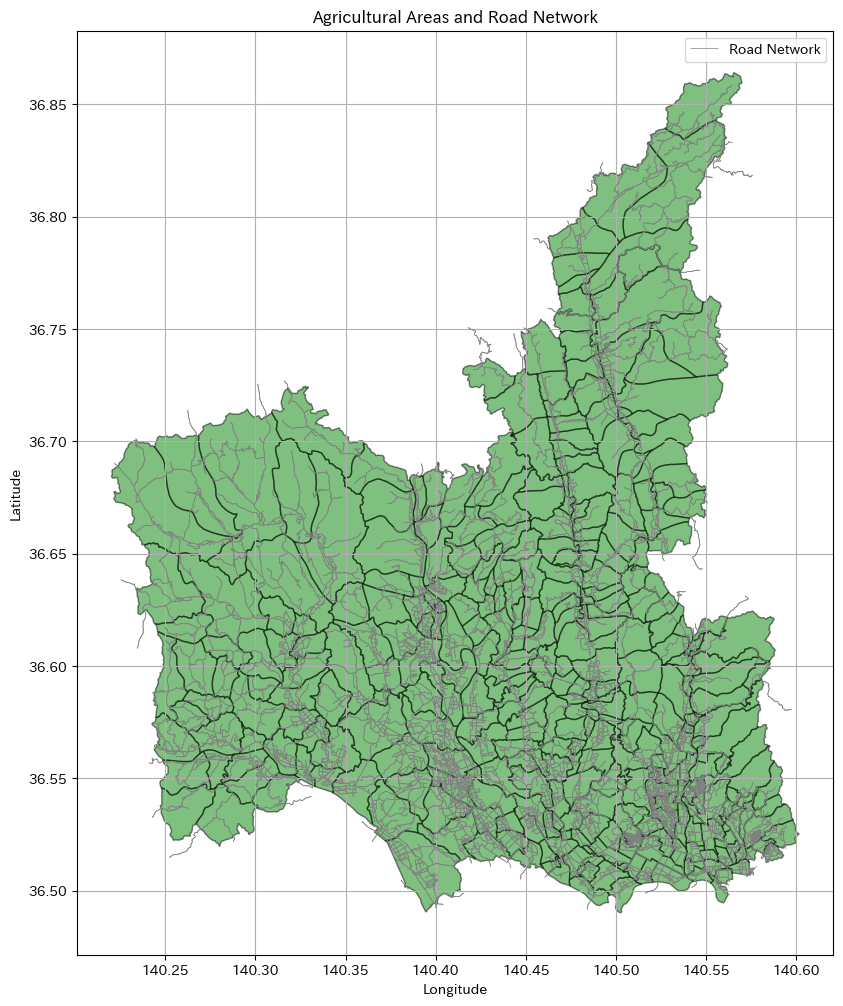

In [4]:
# 描画
fig, ax = plt.subplots(figsize=(12, 12))

# agri_gdf (農地データ) を描画
agri_gdf.plot(ax=ax, color='green', alpha=0.5, edgecolor='black', label="Agricultural Areas")

# 道路ネットワークを描画
road_gdf.plot(ax=ax, color='gray', linewidth=0.5, label="Road Network")

# 描画オプション
plt.legend()
plt.title("Agricultural Areas and Road Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_51783/3229630968.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_51783/3229630968.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


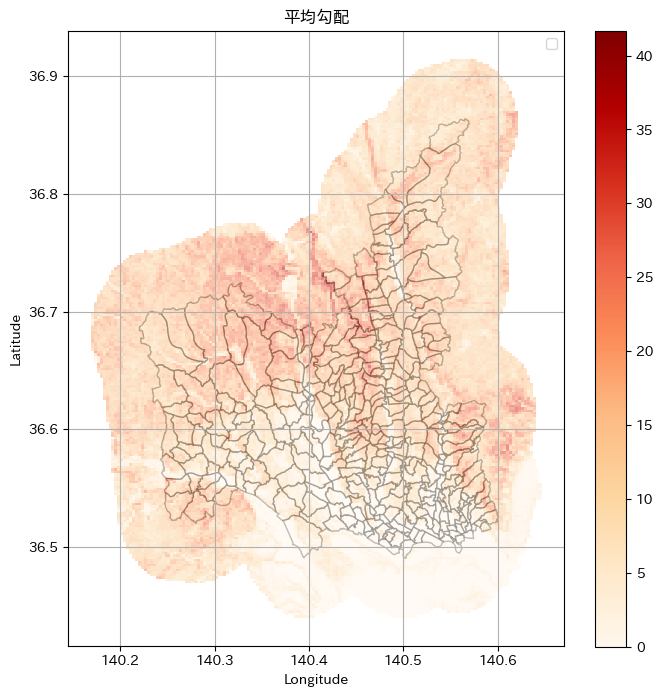

In [5]:
# 描画
fig, ax = plt.subplots(figsize=(8, 8))

# agri_gdf (農地データ) を描画
agri_gdf.plot(ax=ax, color='white', alpha=0.5, edgecolor='black', label="Agricultural Areas")

# 勾配データを描画
dem_gdf['G04d_010_numeric'] = pd.to_numeric(dem_gdf['G04d_010'], errors='coerce')
dem_gdf.plot(column='G04d_010_numeric', alpha=0.5,ax=ax, cmap='OrRd', linewidth=0.5, label="Road Network",legend=True)

# 描画オプション
plt.legend()
plt.title("平均勾配")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

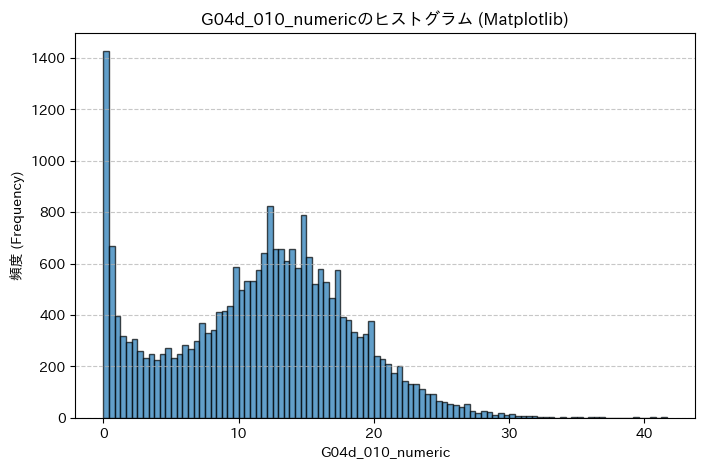

In [6]:
plt.figure(figsize=(8, 5))
plt.hist(dem_gdf['G04d_010_numeric'], bins=100, edgecolor='black', alpha=0.7) # binsの数はデータの分布を見て調整してください
plt.xlabel('G04d_010_numeric')
plt.ylabel('頻度 (Frequency)')
plt.title('G04d_010_numericのヒストグラム (Matplotlib)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_51783/3449143487.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_51783/3449143487.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


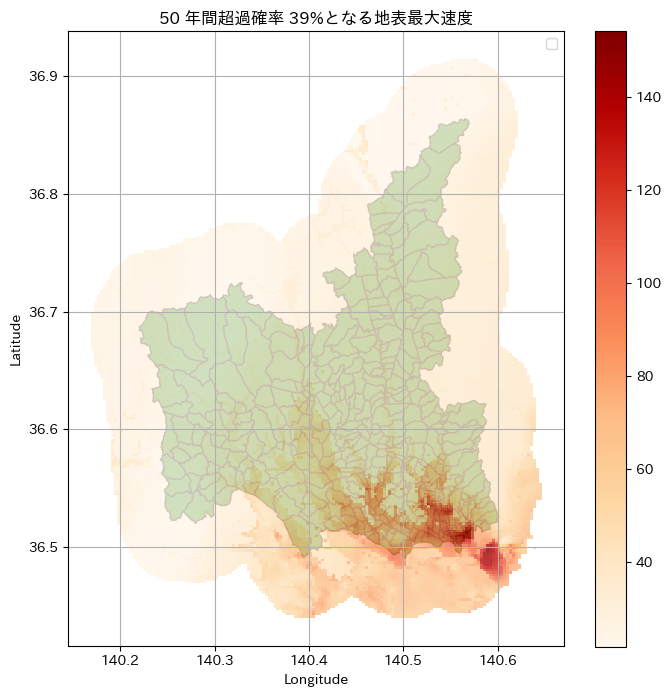

In [7]:
# 描画
fig, ax = plt.subplots(figsize=(8, 8))

# agri_gdf (農地データ) を描画
agri_gdf.plot(ax=ax, color='green', alpha=0.9, edgecolor='black', label="Agricultural Areas")

# 震度データを描画
pgv_gdf.plot(column='T50_P39_SV',ax=ax, cmap='OrRd', alpha=0.8, linewidth=0.5, label="Road Network",legend=True)

# 描画オプション
plt.legend()
plt.title("50 年間超過確率 39%となる地表最大速度")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

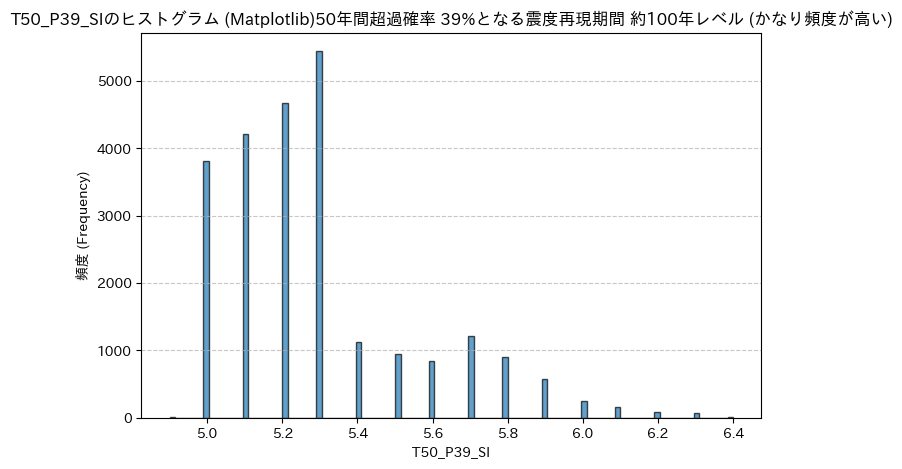

In [8]:
plt.figure(figsize=(8, 5))
plt.hist(pgv_gdf['T50_P39_SI'], bins=100, edgecolor='black', alpha=0.7) # binsの数はデータの分布を見て調整してください
plt.xlabel('T50_P39_SI')
plt.ylabel('頻度 (Frequency)')
plt.title('T50_P39_SIのヒストグラム (Matplotlib)50年間超過確率 39%となる震度再現期間 約100年レベル (かなり頻度が高い)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [9]:
# 出力ファイルパス
RISK_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'risk_gdf.pkl'
SYURAKU_WITH_ISOLATION_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'syuraku_with_isolation_gdf.pkl'
SYURAKU_POP_RISK_GDF_PKL = INTERMEDIATE_OUTPUT_DIR + 'syuraku_pop_risk_gdf.pkl'
with open(RISK_GDF_PKL, 'rb') as file:
    risk_gdf = pickle.load(file)

with open(SYURAKU_WITH_ISOLATION_GDF_PKL, 'rb') as file:
    syuraku_with_isolation_gdf = pickle.load(file)

with open(SYURAKU_POP_RISK_GDF_PKL, 'rb') as file:
    syuraku_pop_risk_gdf = pickle.load(file)

In [10]:
risk_gdf

CODE     pgv                                           geometry  \
0      5440516933  24.495  POLYGON ((140.2375 36.47292, 140.2375 36.475, ...   
1      5440516934  24.572  POLYGON ((140.24063 36.47292, 140.24063 36.475...   
2      5440516942  24.790  POLYGON ((140.24688 36.47083, 140.24688 36.472...   
3      5440516943  24.629  POLYGON ((140.24375 36.47292, 140.24375 36.475...   
4      5440516944  24.679  POLYGON ((140.24688 36.47292, 140.24688 36.475...   
...           ...     ...                                                ...   
24330  5540249621  25.755  POLYGON ((140.58125 36.90833, 140.58125 36.910...   
24331  5540249622  25.913  POLYGON ((140.58438 36.90833, 140.58438 36.910...   
24332  5540249623  25.751  POLYGON ((140.58125 36.91042, 140.58125 36.912...   
24333  5540249631  32.892  POLYGON ((140.575 36.9125, 140.575 36.91458, 1...   
24334  5540249711  26.297  POLYGON ((140.5875 36.90833, 140.5875 36.91042...   

       slope  landslide_prob  
0       19.3        0.679784  
1       21.4        0.721476  
2        4.4        0.354913  
3       17.6        0.647111  
4       11.4        0.509824  
...      ...             ...  
24330   15.5        0.620995  
24331   14.3        0.597187  
24332   14.2        0.592248  
24333   12.0        0.646346  
24334   15.2        0.623295  

[24335 rows x 5 columns]

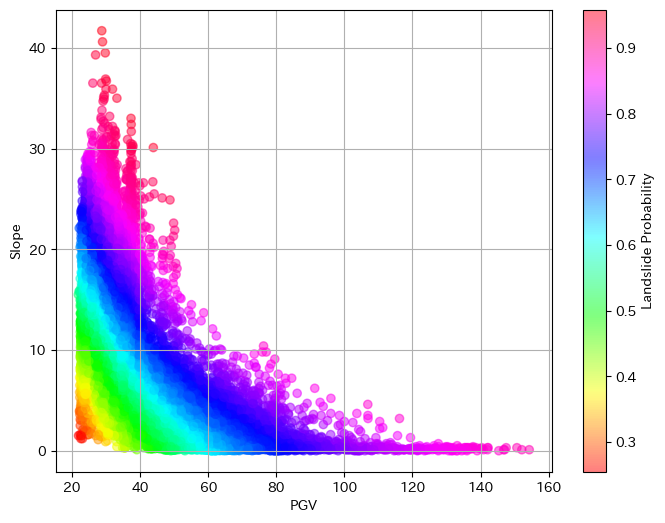

In [11]:
# 1. 基本的な散布図 (matplotlib)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(risk_gdf['pgv'], risk_gdf['slope'], c=risk_gdf['landslide_prob'], cmap='hsv', alpha=0.5)
cbar = plt.colorbar(scatter)
cbar.set_label('Landslide Probability') # カラーバーのラベル
plt.xlabel('PGV')
plt.ylabel('Slope')
plt.grid(True)
plt.show()

/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_48422/932896500.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_48422/932896500.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


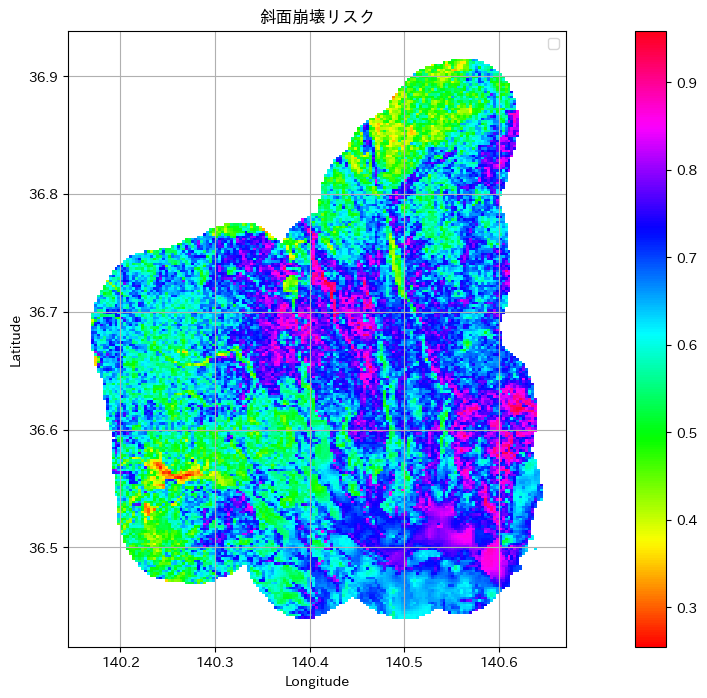

In [61]:
# 描画
f,ax=plt.subplots(figsize=(18,8))
risk_gdf.plot(column='landslide_prob',ax=ax, cmap='hsv', linewidth=0.5, label="Road Network",legend=True)


# 描画オプション
plt.legend()
plt.title("斜面崩壊リスク")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [62]:
road_with_risk = gpd.sjoin(road_gdf[['geometry']], risk_gdf[['landslide_prob', 'geometry']], how="left", predicate="intersects")

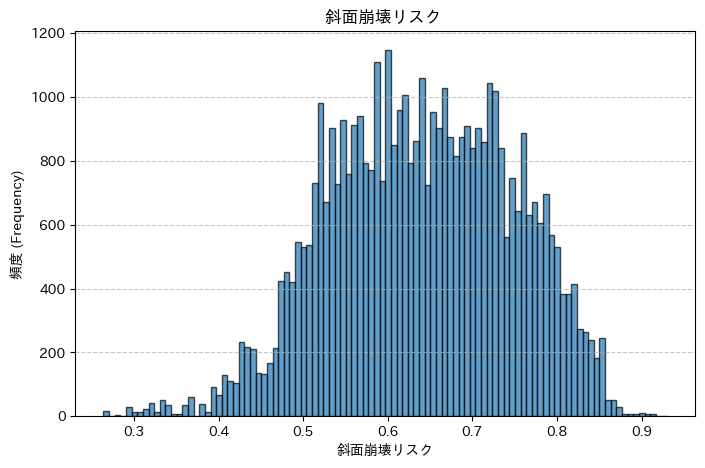

In [63]:
plt.figure(figsize=(8, 5))
plt.hist(road_with_risk['landslide_prob'], bins=100, edgecolor='black', alpha=0.7) # binsの数はデータの分布を見て調整してください
plt.xlabel('斜面崩壊リスク')
plt.ylabel('頻度 (Frequency)')
plt.title('斜面崩壊リスク ')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

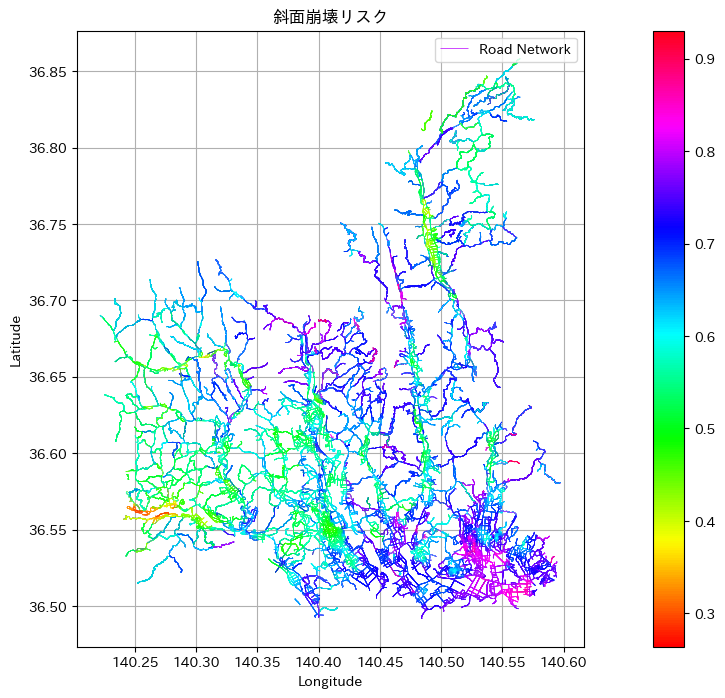

In [64]:
# 描画
f,ax=plt.subplots(figsize=(18,8))
road_with_risk.plot(column='landslide_prob',ax=ax, cmap='hsv', linewidth=0.5, label="Road Network",legend=True)

# 描画オプション
plt.legend()
plt.title("斜面崩壊リスク")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [65]:
road_disruption_prob = 1 - road_with_risk.groupby('geometry')['landslide_prob'].apply(lambda p: (1 - p).prod())
road_disruption_prob.name = 'disruption_prob'
road_with_prob = road_gdf.join(road_disruption_prob, on='geometry')

road_with_prob['disruption_prob'].describe()

count    21784.000000
mean         0.784902
std          0.162089
min          0.291173
25%          0.658152
50%          0.808649
75%          0.930566
max          1.000000
Name: disruption_prob, dtype: float64

若干カウントが違うので後で確認
roadの範囲の指定の仕方が違うみたい。

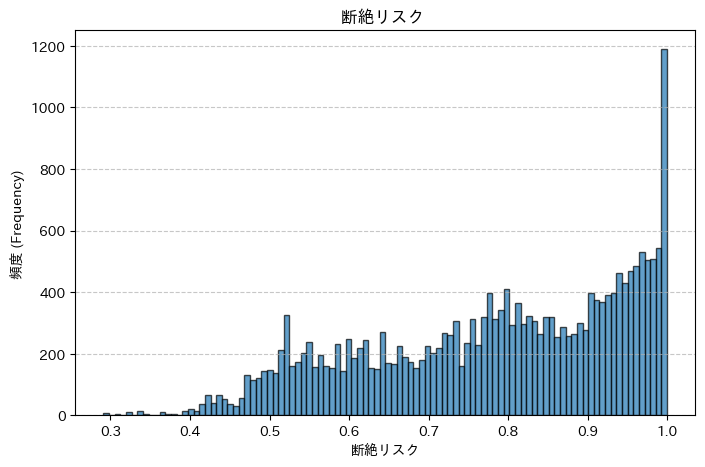

In [67]:
plt.figure(figsize=(8, 5))
plt.hist(road_with_prob['disruption_prob'], bins=100, edgecolor='black', alpha=0.7) # binsの数はデータの分布を見て調整してください
plt.xlabel('断絶リスク')
plt.ylabel('頻度 (Frequency)')
plt.title('断絶リスク ')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

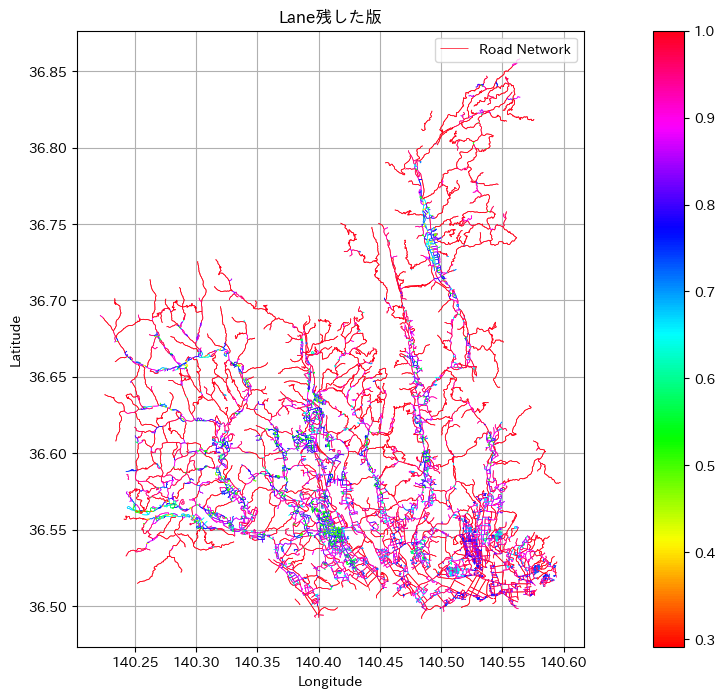

In [68]:
# 描画
f,ax=plt.subplots(figsize=(18,8))
road_with_prob.plot(column='disruption_prob',ax=ax, cmap='hsv', linewidth=0.5, label="Road Network",legend=True)


# 描画オプション
plt.legend()
plt.title("Lane残した版")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [87]:
agri_boundaries = agri_gdf.copy()
agri_boundaries['geometry'] = agri_boundaries.boundary
settlement_road_join = gpd.sjoin(agri_boundaries, road_with_prob[['disruption_prob', 'geometry']], how='left', predicate="intersects")

intersecting_roads = gpd.sjoin(
    road_with_prob[['disruption_prob', 'geometry']],  # 道路データを左側に置く
    agri_boundaries[['geometry']],                  # 集落境界データを右側に置く (geometryのみでOK)
    how='inner',                                 # 交差するものだけを抽出
    predicate='intersects'
)



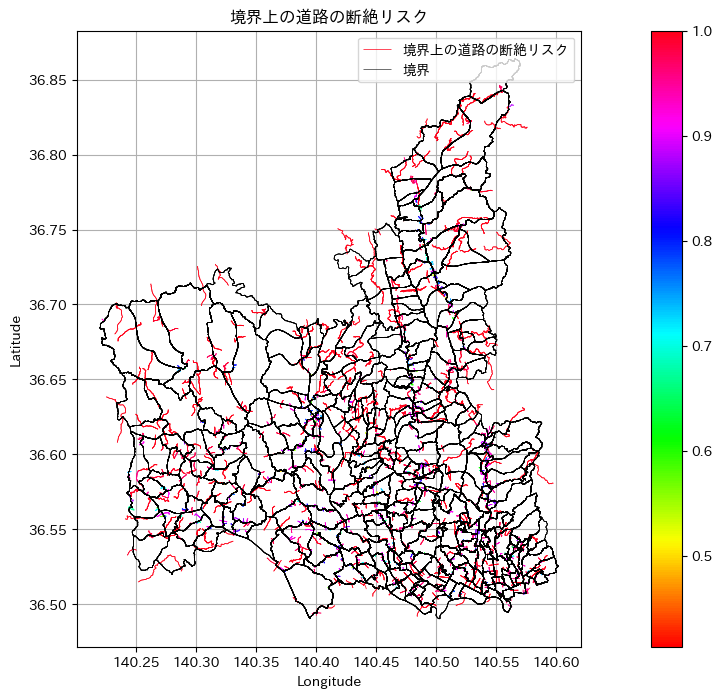

In [88]:
# 描画
f,ax=plt.subplots(figsize=(18,8))


intersecting_roads.plot(column='disruption_prob',ax=ax, cmap='hsv', linewidth=0.5, label="境界上の道路の断絶リスク",legend=True)
settlement_road_join.plot(ax=ax,alpha=0.8, linewidth=0.5, color='black', label="境界")

# 描画オプション
plt.legend()
plt.title("境界上の道路の断絶リスク")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_48422/1185001549.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


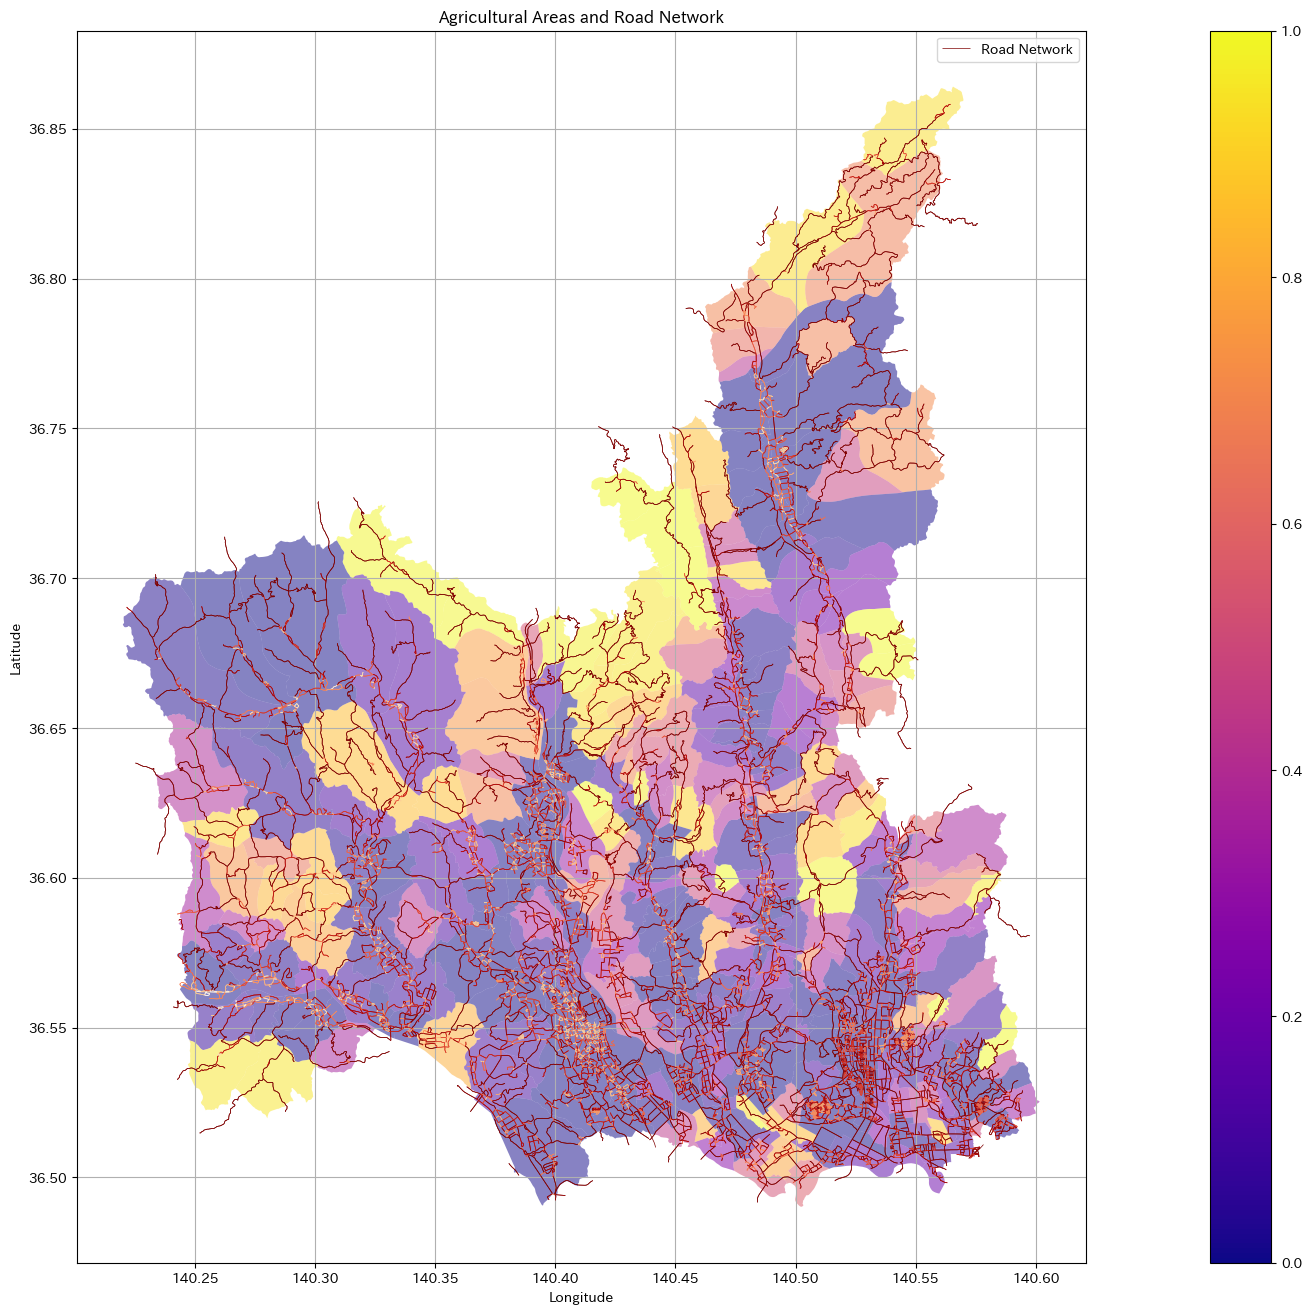

In [92]:
# 描画
f,ax=plt.subplots(figsize=(32,16))

syuraku_with_isolation_gdf.plot(column='isolation_prob',ax=ax, cmap='plasma', alpha=0.5, label="Agricultural Areas",legend=True)
road_with_prob.plot(column='disruption_prob',ax=ax, cmap='OrRd', linewidth=0.5, label="Road Network")

# 描画オプション
plt.legend()
plt.title("Agricultural Areas and Road Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

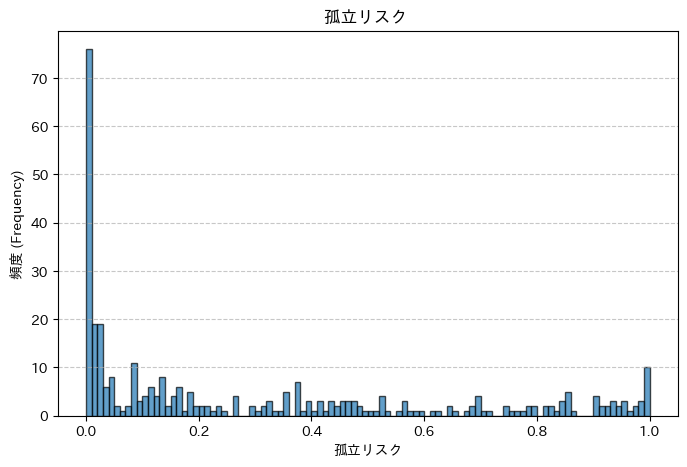

In [93]:
plt.figure(figsize=(8, 5))
plt.hist(syuraku_with_isolation_gdf['isolation_prob'], bins=100, edgecolor='black', alpha=0.7) # binsの数はデータの分布を見て調整してください
plt.xlabel('孤立リスク')
plt.ylabel('頻度 (Frequency)')
plt.title('孤立リスク ')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_48422/2541383892.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  syuraku_pop_risk_gdf['centroid'] = syuraku_pop_risk_gdf.geometry.centroid
/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_48422/2541383892.py:37: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


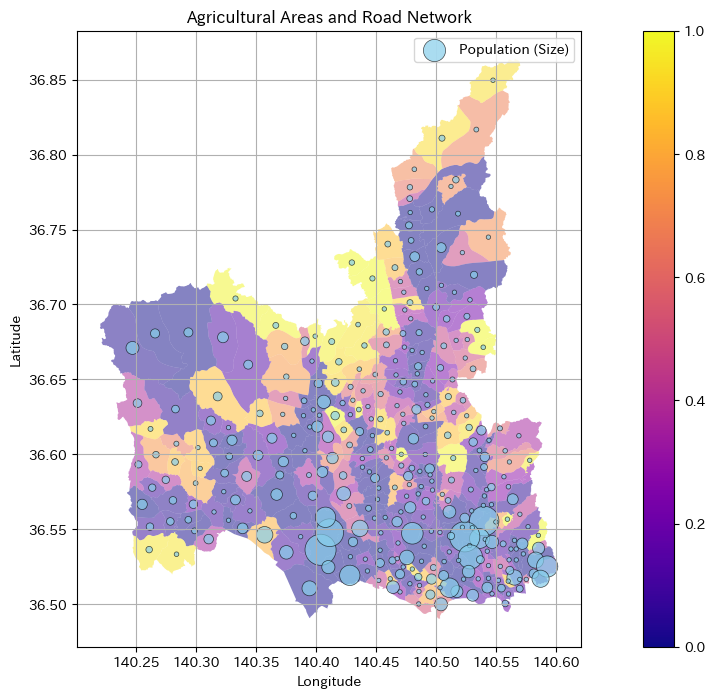

In [ ]:
# 描画
f,ax=plt.subplots(figsize=(16,8))
syuraku_pop_risk_gdf.plot(column='isolation_prob',ax=ax, cmap='plasma', alpha=0.5, label="孤立リスク",legend=True)
syuraku_pop_risk_gdf['centroid'] = syuraku_pop_risk_gdf.geometry.centroid

min_marker_size = 10
max_marker_size = 500
pop_min = syuraku_pop_risk_gdf['total_population'].min()
pop_max = syuraku_pop_risk_gdf['total_population'].max()

# 人口に応じたサイズを計算 (線形スケーリングの例)
# 0除算を避けるための微小値追加や、対数スケールなども検討可能
if pop_max - pop_min > 0:
    sizes = min_marker_size + (syuraku_pop_risk_gdf['total_population'] - pop_min) / (pop_max - pop_min) * (max_marker_size - min_marker_size)
else:
    sizes = np.full(len(syuraku_pop_risk_gdf), min_marker_size) # 人口がすべて同じ場合

# 人口に応じたサイズの円を描画 (重心点に対して)
# 重心点のGeoDataFrameを作成してプロット
centroids_gdf = gpd.GeoDataFrame(
    syuraku_pop_risk_gdf[['total_population']], # 人口データを属性として保持
    geometry=syuraku_pop_risk_gdf['centroid'],
    crs=syuraku_pop_risk_gdf.crs # CRSを引き継ぐ
)

centroids_gdf.plot(
    ax=ax,
    marker='o',       # マーカー形状を円に
    markersize=sizes.tolist(), # サイズのリストを指定 (カラム名での指定は直接できない場合がある)
    color='skyblue',           # 円の色
    edgecolor='black',       # 円の枠線の色
    linewidth=0.5,             # 枠線の太さ
    alpha=0.7,                 # 透明度
    label='Population (Size)'  # 凡例用ラベル (ただし、サイズ凡例は自動生成されない)
)
# 描画オプション
plt.legend()
plt.title("Agricultural Areas and Road Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [130]:
dem_gdf_bounded

G04d_001 G04d_002 G04d_003 G04d_004 G04d_005 G04d_006 G04d_007  \
139166  5440538143     13.5     16.7     10.9        0      2.0        6   
139308  5440548033     10.1     30.0      7.6        0     12.1        7   
139309  5440548034     29.8     31.2     10.7        0     12.4        7   
139953  5440539112     13.8     17.8     11.3        0      3.0        2   
139954  5440539121     15.0     17.5     11.3        0      1.6        6   
...            ...      ...      ...      ...      ...      ...      ...   
180565  5540243514    757.2    800.1    718.9        0     22.8        5   
180566  5540243523    748.2    782.7    699.8        0     23.9        6   
180568  5540243531    778.5    800.3    756.0        0     14.7        7   
180569  5540243532    782.4    801.5    755.5        0     20.9        5   
180570  5540243541    774.8    792.6    741.3        0     21.4        6   

       G04d_008 G04d_009 G04d_010  \
139166      0.2        5      1.1   
139308      0.2        4      2.7   
139309      0.2        7      2.4   
139953      0.1        7      1.2   
139954      0.4        5      1.0   
...         ...      ...      ...   
180565      8.8        3     16.2   
180566      3.8        4     15.5   
180568      2.9        1      8.5   
180569      4.7        3     12.2   
180570      1.7        2     12.0   

                                                 geometry  G04d_010_numeric  
139166  POLYGON ((140.39375 36.48958, 140.39375 36.491...               1.1  
139308  POLYGON ((140.5 36.48958, 140.5 36.49167, 140....               2.7  
139309  POLYGON ((140.50313 36.48958, 140.50313 36.491...               2.4  
139953  POLYGON ((140.39063 36.49167, 140.39063 36.493...               1.2  
139954  POLYGON ((140.39375 36.49167, 140.39375 36.493...               1.0  
...                                                   ...               ...  
180565  POLYGON ((140.56563 36.86042, 140.56563 36.862...              16.2  
180566  POLYGON ((140.56875 36.86042, 140.56875 36.862...              15.5  
180568  POLYGON ((140.5625 36.8625, 140.5625 36.86458,...               8.5  
180569  POLYGON ((140.56563 36.8625, 140.56563 36.8645...              12.2  
180570  POLYGON ((140.56875 36.8625, 140.56875 36.8645...              12.0  

[11648 rows x 12 columns]

/var/folders/dr/zxykd_7d3519k_l3xpcbrg4r0000gn/T/ipykernel_48422/4085840379.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  syuraku_pop_risk_gdf['centroid'] = syuraku_pop_risk_gdf.geometry.centroid


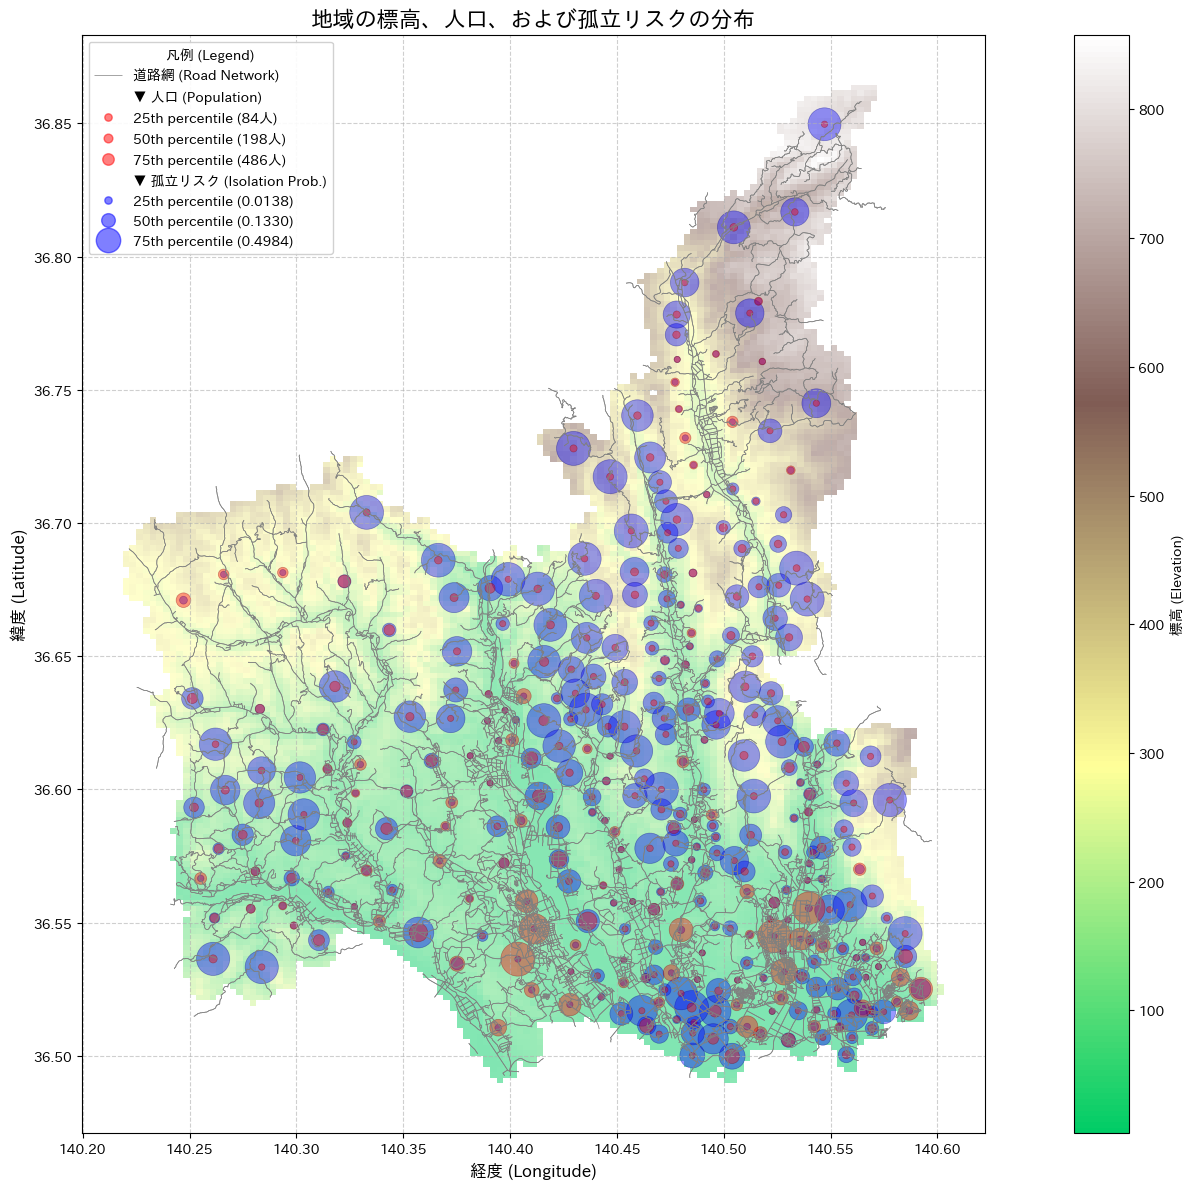

In [ ]:
import matplotlib.lines as mlines
# --- 描画 ---
f, ax = plt.subplots(figsize=(18, 12))

# 1. 標高データのプロット
dem_gdf_bounded = dem_gdf[dem_gdf.intersects(agri_gdf.union_all())].copy()
dem_gdf_bounded["G04d_002_numeric"] = pd.to_numeric(dem_gdf_bounded['G04d_002'], errors='coerce')
dem_gdf_bounded.plot(
    column='G04d_002_numeric', 
    alpha=0.5,
    ax=ax, 
    cmap=cmr.get_sub_cmap(plt.cm.terrain, 0.25, 1.0), 
    linewidth=0.5, 
    legend=True,
    legend_kwds={'label': "標高 (Elevation)"}
)

# 2. 道路ネットワークのプロット
road_gdf.plot(ax=ax, color='gray', linewidth=0.5, label="道路網 (Road Network)")

# 3. 孤立リスク（青い円）のプロット
syuraku_pop_risk_gdf['centroid'] = syuraku_pop_risk_gdf.geometry.centroid
min_marker_size = 20
max_marker_size = 600

# 孤立リスクのサイズ計算
risk_series = syuraku_pop_risk_gdf['isolation_prob']
if risk_series.max() - risk_series.min() > 0:
    risk_sizes = min_marker_size + (risk_series - risk_series.min()) / (risk_series.max() - risk_series.min()) * (max_marker_size - min_marker_size)
else:
    risk_sizes = np.full(len(syuraku_pop_risk_gdf), min_marker_size)

centroids_gdf_risk = gpd.GeoDataFrame(
    syuraku_pop_risk_gdf[['isolation_prob']],
    geometry=syuraku_pop_risk_gdf['centroid'],
    crs=syuraku_pop_risk_gdf.crs
)
centroids_gdf_risk.plot(
    ax=ax, marker='o', markersize=risk_sizes.tolist(),
    color='blue', edgecolor='darkblue', linewidth=0.5, alpha=0.4
)

# 4. 人口（赤い円）のプロット
pop_series = syuraku_pop_risk_gdf['total_population']
if pop_series.max() - pop_series.min() > 0:
    pop_sizes = min_marker_size + (pop_series - pop_series.min()) / (pop_series.max() - pop_series.min()) * (max_marker_size - min_marker_size)
else:
    pop_sizes = np.full(len(syuraku_pop_risk_gdf), min_marker_size)

centroids_gdf_pop = gpd.GeoDataFrame(
    syuraku_pop_risk_gdf[['total_population']],
    geometry=syuraku_pop_risk_gdf['centroid'],
    crs=syuraku_pop_risk_gdf.crs
)
centroids_gdf_pop.plot(
    ax=ax, marker='o', markersize=pop_sizes.tolist(),
    color='red', edgecolor='darkred', linewidth=0.5, alpha=0.4
)

# --- ★★★ ここからが凡例作成部分 ★★★ ---

# 既存の凡例（道路網など）を取得
handles, labels = ax.get_legend_handles_labels()

# --- サイズ凡例の作成 ---
def create_size_legend_handles(series, color, label_prefix):
    """データから代表値を抽出し、パーセンタイルで凡例用のダミープロットを作成する"""
    series_clean = series[series > 0]
    if series_clean.empty:
        return []

    # 凡例に表示するパーセンタイルのリスト
    percentiles = [25, 50, 75]
    
    # 凡例のタイトルを追加
    handles = [mlines.Line2D([], [], color='none', marker='None', linestyle='None', label=f'▼ {label_prefix}')]
    
    for p in percentiles:
        val = np.percentile(series_clean, p)
        
        # プロットと同じスケーリングでサイズを計算
        if series.max() - series.min() > 0:
            size = min_marker_size + (val - series.min()) / (series.max() - series.min()) * (max_marker_size - min_marker_size)
        else:
            size = min_marker_size
        
        # 凡例のラベルを作成 (パーセンタイルと実際の値)
        if '人口' in label_prefix:
            label = f'{p}th percentile ({val:,.0f}人)'
        else:
            label = f'{p}th percentile ({val:.4f})'
        
        # 凡例ハンドルを作成
        handles.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                                      markersize=np.sqrt(size), # 凡例のmarkersizeは平方根をとる
                                      label=label, alpha=0.5))
    return handles

# 人口と孤立リスクのサイズ凡例ハンドルを作成
pop_handles = create_size_legend_handles(pop_series, 'red', '人口 (Population)')
risk_handles = create_size_legend_handles(risk_series, 'blue', '孤立リスク (Isolation Prob.)')

# すべての凡例要素を結合
all_handles = handles + pop_handles + risk_handles

# 凡例を表示
ax.legend(handles=all_handles, loc='upper left', frameon=True, framealpha=0.9, title='凡例 (Legend)')

# --- グラフ全体の仕上げ ---
ax.set_title("地域の標高、人口、および孤立リスクの分布", fontsize=16)
ax.set_xlabel("経度 (Longitude)", fontsize=12)
ax.set_ylabel("緯度 (Latitude)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


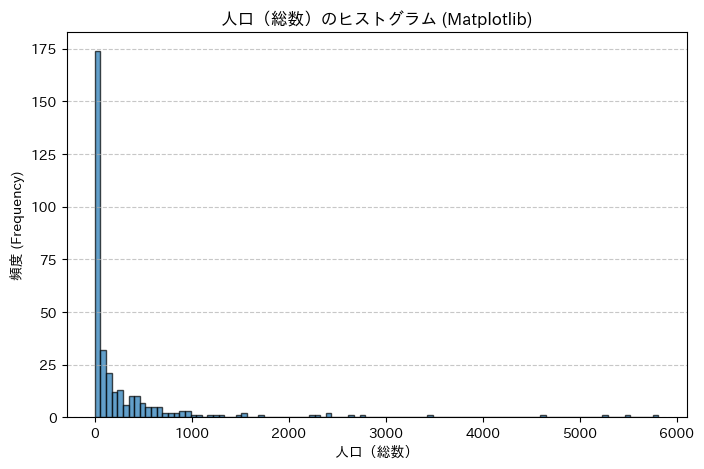

In [104]:
plt.figure(figsize=(8, 5))
plt.hist(syuraku_pop_risk_gdf['total_population'], bins=100, edgecolor='black', alpha=0.7) # binsの数はデータの分布を見て調整してください
plt.xlabel('人口（総数）')
plt.ylabel('頻度 (Frequency)')
plt.title('人口（総数）のヒストグラム (Matplotlib)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

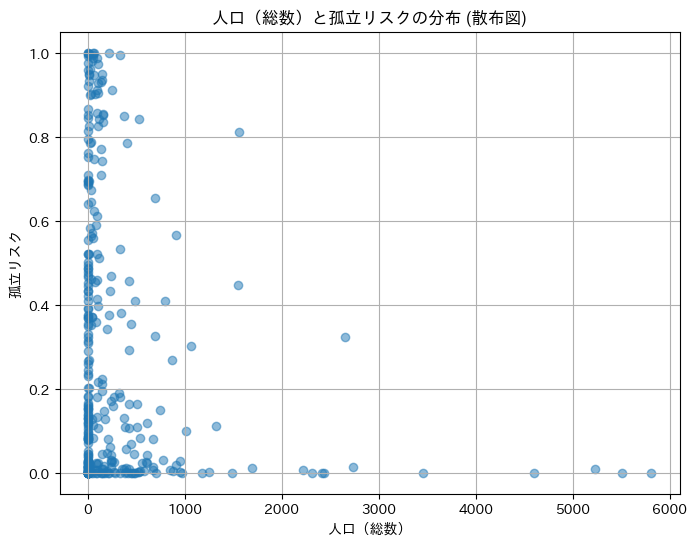

In [105]:
# 1. 基本的な散布図 (matplotlib)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(syuraku_pop_risk_gdf['total_population'], syuraku_pop_risk_gdf['isolation_prob'], alpha=0.5)
plt.xlabel('人口（総数）')
plt.ylabel('孤立リスク')
plt.title('人口（総数）と孤立リスクの分布 (散布図)')
plt.grid(True)
plt.show()

In [109]:
# 出力ファイルパス
DESTINATION_NODES_PKL = INTERMEDIATE_OUTPUT_DIR + 'destination_nodes.pkl'
FACILITY_NODES_PKL = INTERMEDIATE_OUTPUT_DIR + 'facility_nodes.pkl'
with open(DESTINATION_NODES_PKL, 'rb') as file:
    destination_nodes = pickle.load(file)

with open(FACILITY_NODES_PKL, 'rb') as file:
    facility_nodes = pickle.load(file)

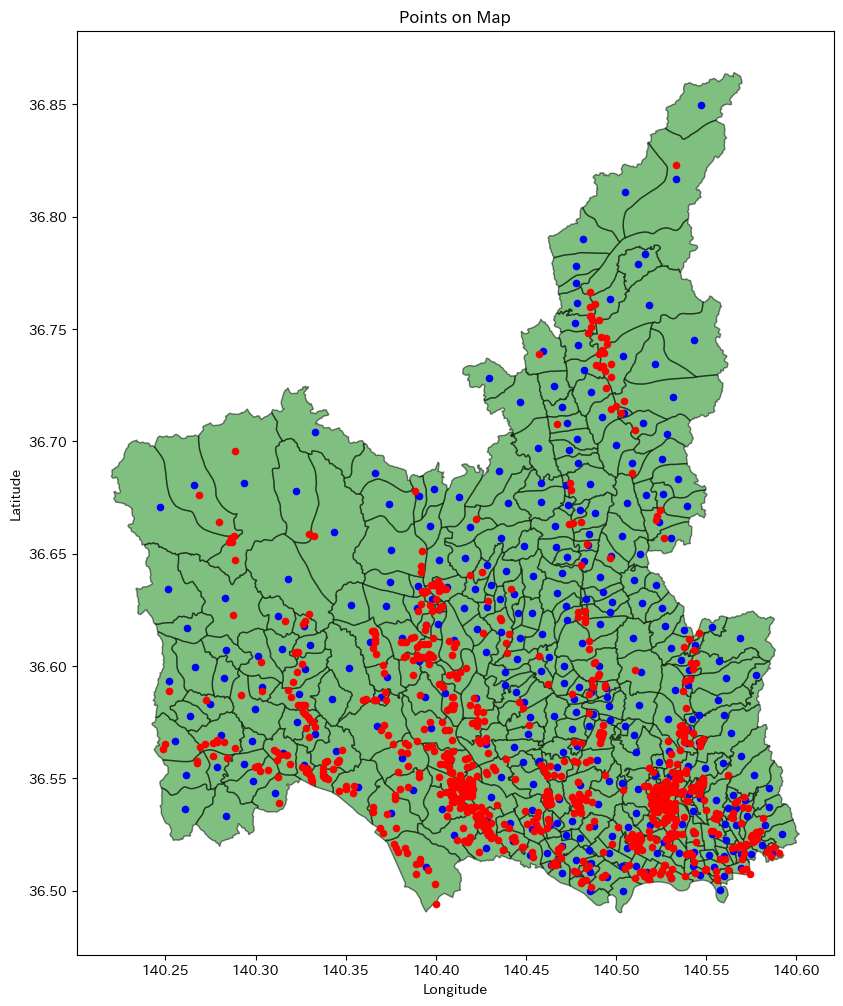

In [110]:

# 描画
fig, ax = plt.subplots(figsize=(12, 12))

# agri_df (農地データ) をプロット
agri_gdf.plot(ax=ax, color='green', alpha=0.5, edgecolor='black', label="Agricultural Areas")

# 各ノードをプロット
destination_nodes.plot(ax=ax,marker="o", color="blue", markersize=20)
facility_nodes.plot(ax=ax,marker="o", color="red", markersize=20)

plt.title("Points on Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()